### Importing necessary packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as sts
import pandas as pd

### Data preparation

A rainfall study divided Pakistan into 5 zones (Salma et.al., 2012) based on rainfall trends. The main essence of this division is latitude. I have taken 5 cities from each of the zones to design the CA model with the 5 cities forming one row of the final grid.

In [2]:
# names of all the cities
names = ['Swat', 'Skardu', 'Kohistan', 'Gilgit', 'Muzaffarabad', 'Swabi', 'Mianwali', 'Gujrat', 'Nowshera',
         'Jhelum', 'TTK', 'Chiniot', 'Lahore', 'Bhakkar', 'Jhang', 'Lodhran', 'Muzaffargarh', 'Multan', 'DGK', 
         'Bahawalpur', 'Karachi', 'Sukkur', 'Larkana', 'Nawabshah', 'Kashmore']
# respective altitudes of the cities
altitudes = [980, 2228, 1650, 1500, 737, 340, 210, 1110, 552, 234, 149, 179, 217, 159, 158, 106, 123, 122, 390, 118, 
            10, 67, 147, 34, 66]
# average rain fall per annum
precipitation = [0.67]*5 + [0.65]*5 + [0.33]*5 + [0.22]*5 + [0.29]*5
# percentage of days it rains on average in respective cities
percentage_days = [50]*2 + [45, 50, 45] + [30]*5 + [20]*5 + [10]*5 + [15]*5
# average rainfall per rain
height_per_rain = [precipitation[i]/(60*(percentage_days[i]/100)) for i in range(len(precipitation))]
# whether soil is waterlogged or not
soil = [0,0,1] + [0]*3 + [1]*4 + [0,1,0,0,0]*2 + [1]*2 + [0]*3
# all cities start off as not flooded
flooded = [False]*25
# does the city have a water body nearby to act as natural drainage
water_body = [0]*5 + [1]*18 + [0,0]
barrage = [0]*25

data = pd.DataFrame({
    'Names': names,
    'Altitude in meters': altitudes,
    'Annual Precipitation in meters': precipitation,
    'Rainy days as %age': percentage_days,
    'Average Rainfall in meters': height_per_rain,
    'Soil': soil,
    'Flooded': flooded, 
    'Water Body present?': water_body,
    'Barrage': barrage
})
data

,Names,Altitude in meters,Annual Precipitation in meters,Rainy days as %age,Average Rainfall in meters,Soil,Flooded,Water Body present?,Barrage
0,Swat,980,0.67,50,0.022333,0,False,0,0
1,Skardu,2228,0.67,50,0.022333,0,False,0,0
2,Kohistan,1650,0.67,45,0.024815,1,False,0,0
3,Gilgit,1500,0.67,50,0.022333,0,False,0,0
4,Muzaffarabad,737,0.67,45,0.024815,0,False,0,0
5,Swabi,340,0.65,30,0.036111,0,False,1,0
6,Mianwali,210,0.65,30,0.036111,1,False,1,0
7,Gujrat,1110,0.65,30,0.036111,1,False,1,0
8,Nowshera,552,0.65,30,0.036111,1,False,1,0
9,Jhelum,234,0.65,30,0.036111,1,False,1,0


In [3]:
class Cell:
    '''
    Class to form a cell in the grid
    
    Attributes
    ----------
        name: str
            Name of the city
        altitude: int
            Altitude above sea level of the city
        precipitation: int
            total rainfall in the city per annum
        rainy_days: int
            Percentage of days in the year the city experiences rainfall
        height_per_rain: float
            millimeters of rain per rainfall on average
        soil: int
            1 if soil is waterlogged, 0 otherwise
        flooded: boolean
            whether the city is flooded or not
        water_body: int
            1 if city has a water body nearby, 0 otherwise
        net_height: float
            Total height of the city depending on the water level of the soil as well
        overflow: float
            Excess water that is not absorbed by the soil and needs to be drained
        net_rain: float
            Total amount of rain over a period of time
        barrage: int
            1 if the city is protected by a barrage, 0 otherwise
        
    '''
    def __init__(self, name, altitude, precipitation, percentage_days, height_per_rain, soil, flooded, water_body, barrage):
        '''
        Method to make the instance of the class.
        
        Parameters
        ----------
            name: str
            altitude: int
            precipitation: int
            percentage_days: int
            height_per_rain: float
            soil: int
            flooded: boolean
            water_body: int
            barrage: int
            
        Features
        --------
        If the soil is not water-logged, it still has capacity to absorb water so we its capacity is to absorb
        1.5 m of water. If the soil is water-logged, it only has a capacity of 0.5 m of water. 
        '''
        self.name = name
        self.water_body = water_body
        self.altitude = altitude
        self.precipitation = precipitation
        self.rainy_days = percentage_days
        self.height_per_rain = height_per_rain
        self.soil = soil
        self.flooded = flooded
        if self.soil == 0:
            self.water = -2
        else:
            self.water = -0.6
        self.net_height = self.altitude + self.water
        self.overflow = 0
        self.net_rain = 0
        self.barrage = barrage
        
    def update(self, prob):
        '''
        Method to update the water condition within the cell and simulate the rain
        '''
        # check whether rain happens given the probability of a rainy day
        if random.random() < self.rainy_days/100:
            # if it is gonna rain, simulate amount of rain through a gamma distribution
            # a gamma distribution was chosen because it is defined between 0 and +inf which
            # is the range of amount of rain
            rain = sts.gamma(self.height_per_rain, 0.3).rvs()
        else:
            rain = 0
        # add rain amount to total rain
        self.net_rain += rain
        
        # add rain to water levels in the city
        self.water += rain
        # if water level has reached ground level, soil is water logged
        if self.water == 0:
            self.soil = 1
        # if water level is above ground level
        elif self.water > 0:
            # how much water is overflowing
            self.overflow += self.water
            # set water level to ground as water overflows
            self.water = 0
            # city is flooded
            self.flooded = True
            # soil is water-logged
            self.soil = 1
            # net height of the city is now altitude + water level + overflowing water
            self.net_height = self.altitude + self.water + self.overflow
            
        else:
            # if soil is not water logged
            if self.soil == 0:
                # water is absorbed into the ground with a 60% probability, restoring original levels
                if random.random() < prob:
                    self.water = -2
                # else: water level goes down by 1 mm per day
                elif self.water-0.2 >= -2:
                    self.water -= 0.2
            else:
                # if soil is water logged, 10% chance of being restored to original levels
                if random.random() < prob/6:
                    self.water = -0.6
                else:
                    # water level does not change
                    self.water = self.water
                    
    def update_flood(self):
        '''
        Method to update the flood status of the cell
        '''
        # if water level is below ground level, not flooded
        if self.water + self.overflow <= 0:
            self.flooded = False
        # if above ground level, it is flooded
        else:
            self.flooded = True

In [4]:
class Grid:
    '''
    Class for the grid and the simulation
    
    Attributes
    ----------
        n: int
            Number of rows and columns
        rows: int
            Number of rows in the grid
        columns: int
            Number of columns in the grid
        cells: list
            the grid which contains all the instances of the cells
        prob: float
            probability with which water level restores to its original level
    '''
    def __init__(self, n = 5, drainage_prob = 0.6):
        '''
        Method to initiate the class when it is called
        
        Parameters
        ----------
            n: int
                default value = 5. Number of rows and columns
            drainage_prob: float
                default value = 0.6. Probability with which old water levels are restored.
        '''
        self.n = n
        self.prob = drainage_prob
        self.rows = self.n
        self.columns = self.n
        self.cells = []
        self.flow = []
        
        # make the grid
        for i in range(n):
            # make an empty row
            row = []
            for j in range(n):
                # make instances for the cells
                cell = self.getCell(names[(i*5)+j], altitudes[(i*5)+j], precipitation[(i*5)+j], percentage_days[(i*5)+j],
                       height_per_rain[(i*5)+j], soil[(i*5)+j], flooded[(i*5)+j], water_body[(i*5)+j], barrage[(i*5)+j])
                # append the cell to the row
                row.append(cell)
            # append the row to the grid
            self.cells.append(row)
            
    def getCell(self, name, altitude, precipitation, percentage_days, height_per_rain, soil, flooded, water_body, barrage):
        '''
        Method to make an instance of a cell
        
        Parameters
        ----------
            name: str
            altitude: int
            precipitation: int
            percentage_days: int
            height_per_rain: float
            soil: int (0 or 1)
            flooded: boolean
            water_body: int (0 or 1)
            barrage: int (0 or 1)
        '''
        # makes an instance of the Cell class and returns it
        return Cell(name, altitude, precipitation, percentage_days, height_per_rain, soil, flooded, water_body, barrage)
    
    def getCells(self):
        '''
        Method to return all the cells in the grid
        '''
        return self.cells
    
    def observe(self, attribute):
        '''
        Method to plot the grid
        
        Parameters
        ----------
            attribute: str
                the attribute that you want to observe. Can be any one from the attributes of the Cell class.
        '''
        # get all the cells from the grid
        a = self.getCells()
        # make an empty list to flatten the cells
        all_cells = []
        # loop over the grid and append all the cells into a flat array
        for i in range(len(a)):
            for j in range(len(a)):
                all_cells.append(a[i][j])
        # make an array by retrieving the attribute under consideration for all the cells and make a grid again
        attributes = np.array([getattr(all_cells[i], attribute) for i in range(len(all_cells))]).reshape(5,5)
        # make the plot
        plt.figure()
        c = plt.imshow(attributes)
        plt.title(str(attribute))
        plt.colorbar(c)
        plt.show()
        
    def retrieve(self, attribute):
        '''
        Method to retrieve a grid of the specific attribute that we are looking for
        '''
        # get all the cells
        a = self.getCells()
        # flatten the grid
        flattened = np.array(a).flatten()
        # retrieve attribute and reshape to form the grid
        attribute_grid = np.array([getattr(flattened[i], attribute) for i in range(len(flattened))]).reshape(self.n, self.n)
        return attribute_grid
    
    def percolation_test(self):
        '''
        Method to check for percolation
        '''
        
        # set default percolation to be False
        percolation = False
        # loop over each of the columns
        for y in range(self.n):
            # set flow to be True by default
            flow = True
            # retrieve cells for the columns
            a = [g.getCells()[x][y] for x in range(self.n)]
            # get water levels for all the cells in the column
            water_levels = [x.water for x in a]
            # loop over the cells and check if any is not flooded
            for level in water_levels:
                if level < 0:
                    # if any of the cells is not flooded, percolation doesn't occur and water is not flowing
                    flow = False
            if flow == True:
                # if flow is true i.e. all cells are flooded, set percolation to be True
                percolation = True
        # return the percolation variable
        return percolation
            
    
    def update(self):
        '''
        Method to update the entire system
        '''
        flow = 0
        
        #update all cells on their own first i.e. check to see if rain happened
        for x in range(self.n):
            for y in range(self.n):
                self.cells[x][y].update(self.prob)
        
        # update top row
        for y in range(self.n):
            x = 0
            current = self.cells[x][y]
            # make an empty array for neighbors
            neighbors = []
            # using a Von-Neuman neighborhood but not periodic conditions. Boundaries on the vertical axes are cut off.
            for dx, dy in [(1, 0), (0, -1), (0, 1)]:
                # append all the neighbors into the array
                neighbors.append(self.cells[dx][(y+dy)%self.n])
            # get height of the cell under consideration
            current_height = current.net_height
            # set steepest neighbor to be None by default in case our cell is in a valley
            steepest_neighbor = None
            # loop through the neighbors
            for n in neighbors:
                # if the neighbor is lower than current cell
                if n.net_height < current_height:
                    # if the steepest neighbor is None, set it to current neighbor
                    if steepest_neighbor == None:
                        steepest_neighbor = n
                        flow += 1
                    # if there is already a neighbor, compare the heights and choose the one with steepest decline
                    else:
                        if n.net_height < steepest_neighbor.net_height:
                            steepest_neighbor = n
                    
            #water flows to steepest neighbor
            if current.overflow > 0 and steepest_neighbor != None:
                # if the neighbor has a barrage, the water will be stopped by it and absorbed into the surrounding soil
                if steepest_neighbor.barrage == 1:
                    steepest_neighbor.water += 0
                else:
                    # if the steepest neighbor has a water body near it, most of the water drains into the water body
                    # rather than to the city. Only 30% of the overflow makes it to the neighboring cell
                    if steepest_neighbor.water_body == 1:
                        steepest_neighbor.water += current.overflow * 0.3
                    else:
                        steepest_neighbor.water += current.overflow
                # once water has flown to the neighbor, current overflow becomes 0
                current.overflow = 0
                # update the neighbor based on water flow
                # neighbor becomes water logged if overflow caused its water level to come level with the ground
                if steepest_neighbor.water == 0:
                    steepest_neighbor.soil = 1
                # if water level is above the ground level
                elif steepest_neighbor.water > 0:
                    # set the overflow value
                    steepest_neighbor.overflow += steepest_neighbor.water
                    steepest_neighbor.water = 0
                    # set neighbor to be flooded
                    steepest_neighbor.flooded = True
                    # eighbor's soil becomes water logged
                    steepest_neighbor.soil = 1
                    # update neighbor's height
                    steepest_neighbor.net_height = steepest_neighbor.altitude + steepest_neighbor.water + steepest_neighbor.overflow
            
        # update all except boundaries
        for x in range(1, self.n-1):
            for y in range(self.n):
                current = self.cells[x][y]
                neighbors = []
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    neighbors.append(self.cells[(x+dx)%self.n][(y+dy)%self.n])
                # find steepest neighbor
                current_height = current.net_height
                steepest_neighbor = None
                for n in neighbors:
                    if n.net_height < current_height:
                        # steep comparison
                        if steepest_neighbor == None:
                            steepest_neighbor = n
                            flow += 1
                        else:
                            if n.net_height < steepest_neighbor.net_height:
                                steepest_neighbor = n
                    
                #water flows to steepest neighbor
                if current.overflow > 0 and steepest_neighbor != None:
                    # if the neighbor has a barrage, the water will be stopped by it and absorbed into the surrounding soil
                    if steepest_neighbor.barrage == 1:
                        steepest_neighbor.water += 0
                    else:
                        # if the steepest neighbor has a water body near it, most of the water drains into the water body
                        # rather than to the city. Only 30% of the overflow makes it to the neighboring cell
                        if steepest_neighbor.water_body == 1:
                            steepest_neighbor.water += current.overflow * 0.3
                        else:
                            steepest_neighbor.water += current.overflow
                    current.overflow = 0
                    if steepest_neighbor.water == 0:
                        steepest_neighbor.soil = 1
                    elif steepest_neighbor.water > 0:
                        steepest_neighbor.overflow += steepest_neighbor.water
                        steepest_neighbor.water = 0
                        steepest_neighbor.flooded = True
                        steepest_neighbor.soil = 1
                        steepest_neighbor.net_height = steepest_neighbor.altitude + steepest_neighbor.water + steepest_neighbor.overflow

                
        # update bottom row
        for y in range(self.n):
            x = 4
            neighbors = []
            current = self.cells[x][y]
            for dx, dy in [(-1, 0), (0, -1), (0, 1)]:
                neighbors.append(self.cells[(x+dx)%self.n][(y+dy)%self.n])
            # find steepest neighbor
            current_height = current.net_height
            steepest_neighbor = None
            for n in neighbors:
                if n.net_height < current_height:
                    # steep comparison
                    if steepest_neighbor == None:
                        steepest_neighbor = n
                        flow += 1
                    else:
                        if n.net_height < steepest_neighbor.net_height:
                            steepest_neighbor = n
                    
            #water flows to steepest neighbor
            if current.overflow > 0 and steepest_neighbor != None:
                # if the neighbor has a barrage, the water will be stopped by it and absorbed into the surrounding soil
                if steepest_neighbor.barrage == 1:
                    steepest_neighbor.water += 0
                else:
                    # if the steepest neighbor has a water body near it, most of the water drains into the water body
                    # rather than to the city. Only 30% of the overflow makes it to the neighboring cell
                    if steepest_neighbor.water_body == 1:
                        steepest_neighbor.water += current.overflow * 0.3
                    else:
                        steepest_neighbor.water += current.overflow
                current.overflow = 0
                if steepest_neighbor.water == 0:
                    steepest_neighbor.soil = 1
                elif steepest_neighbor.water > 0:
                    steepest_neighbor.overflow += steepest_neighbor.water
                    steepest_neighbor.water = 0
                    steepest_neighbor.flooded = True
                    steepest_neighbor.soil = 1
                    steepest_neighbor.net_height = steepest_neighbor.altitude + steepest_neighbor.water + steepest_neighbor.overflow

        self.flow.append(flow/(self.n * self.n))

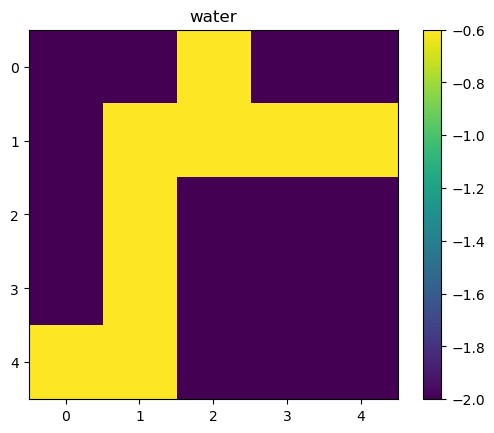

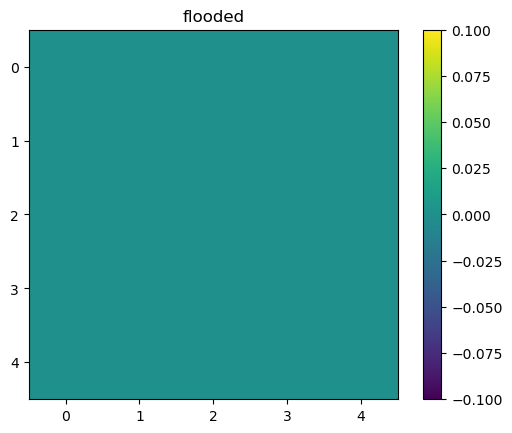

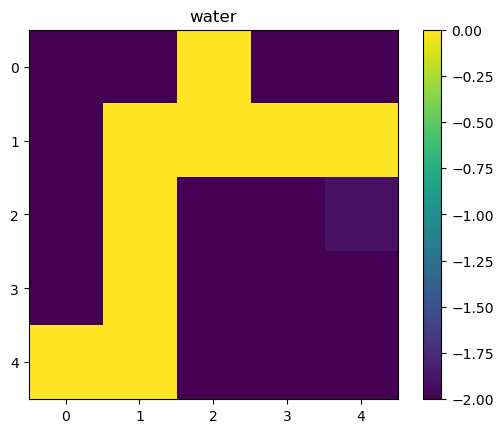

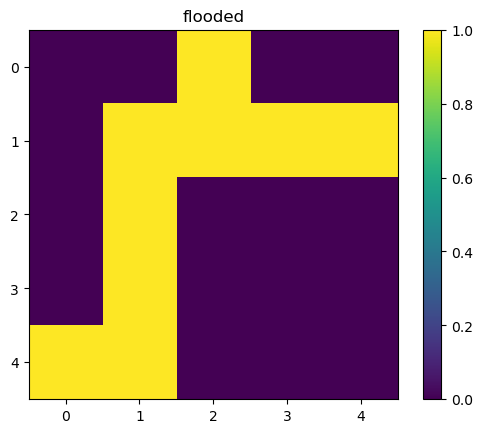

False


In [5]:
# make an instance of the Grid
g = Grid()
# observe initial conditions of water levels and flooding
g.observe('water')
g.observe('flooded')
# update for 60 days i.e. length of the moonsoon season
for i in range(60):
    g.update()
# observe final conditions
g.observe('water')
g.observe('flooded')
# check whether percolation occurs or not
print(g.percolation_test())

In [6]:
for i in range(100):
    g = Grid()
    for j in range(365):
        g.update()
    if g.percolation_test == True:
        g.observe('flooded')

In [7]:
#empirical runs
results_old = []
for i in range(1000):
    g = Grid()
    for j in range(60):
        g.update()
    if g.percolation_test() == False:
        results_old.append(0)
    else:
        results_old.append(1)

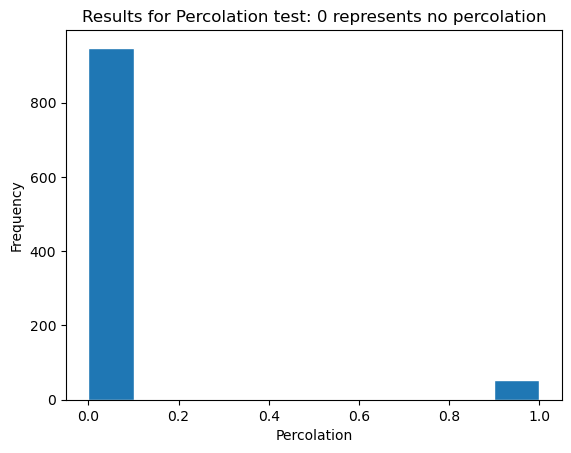

In [8]:
plt.figure()
plt.title('Results for Percolation test: 0 represents no percolation')
plt.hist(results_old, edgecolor = 'white')
plt.xlabel('Percolation')
plt.ylabel('Frequency')
plt.show()

In [9]:
# check for mean water levels in the grid at the end of the moonsoon season
mean_water_old = []
for i in range(1000):
    g = Grid()
    for j in range(60):
        g.update()
    water_levels = np.array(g.retrieve('water')).flatten()
    mean_water_old.append(np.mean(water_levels))

In [10]:
def confint(lst):
    '''
    Function for calculating confidence intervals of a given list
    
    Inputs
    ------
        lst: list
            list of the data
    Outputs
    -------
        confint: list
            list of two values of confidence intervals.
    '''
    mean = np.mean(lst)
    standard_error = sts.sem(lst)
    deviation = standard_error * 1.96
    return [mean - deviation, mean + deviation]

confint_old = confint(mean_water_old)

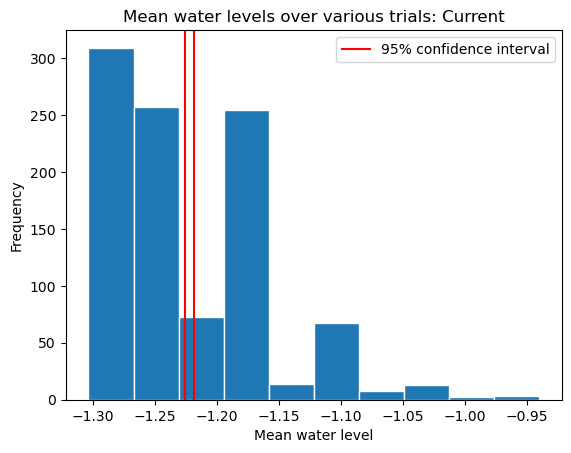

95% Confidence interval:  [-1.2258314132398211, -1.218445097265094]


In [11]:
plt.figure()
plt.title('Mean water levels over various trials: Current')
plt.hist(mean_water_old, edgecolor = 'white', bins = 10)
plt.axvline(confint_old[0], label = '95% confidence interval', color = 'red')
plt.axvline(confint_old[1], color = 'red')
plt.legend()
plt.xlabel('Mean water level')
plt.ylabel('Frequency')
plt.show()
print('95% Confidence interval: ', confint_old)

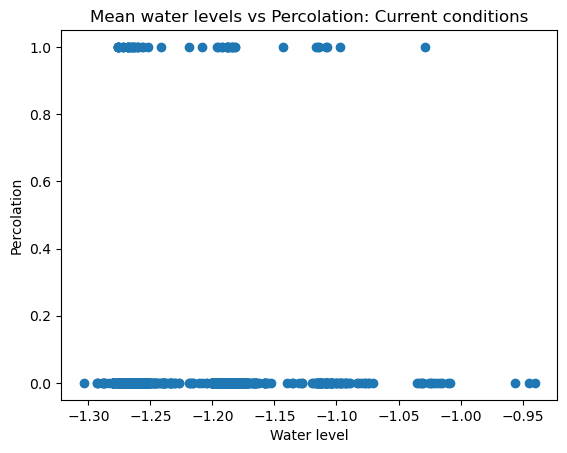

In [12]:
plt.figure()
plt.scatter(mean_water_old, results_old)
plt.title('Mean water levels vs Percolation: Current conditions')
plt.xlabel('Water level')
plt.ylabel('Percolation')
plt.show()

## New conditions

In [13]:
# run a small number of trials to see where the problem is
for i in range(5):
    g = Grid()
    for j in range(60):
        g.update()
    if g.percolation_test() == True:
        g.observe('flooded')

In [14]:
# add barrages
barrage = [0]*10 + [1,1,1,0,0]*3

data = pd.DataFrame({
    'Names': names,
    'Altitude in meters': altitudes,
    'Annual Precipitation in meters': precipitation,
    'Rainy days as %age': percentage_days,
    'Average Rainfall in meters': height_per_rain,
    'Soil': soil,
    'Flooded': flooded, 
    'Water Body present?': water_body,
    'Barrage': barrage
})
data

,Names,Altitude in meters,Annual Precipitation in meters,Rainy days as %age,Average Rainfall in meters,Soil,Flooded,Water Body present?,Barrage
0,Swat,980,0.67,50,0.022333,0,False,0,0
1,Skardu,2228,0.67,50,0.022333,0,False,0,0
2,Kohistan,1650,0.67,45,0.024815,1,False,0,0
3,Gilgit,1500,0.67,50,0.022333,0,False,0,0
4,Muzaffarabad,737,0.67,45,0.024815,0,False,0,0
5,Swabi,340,0.65,30,0.036111,0,False,1,0
6,Mianwali,210,0.65,30,0.036111,1,False,1,0
7,Gujrat,1110,0.65,30,0.036111,1,False,1,0
8,Nowshera,552,0.65,30,0.036111,1,False,1,0
9,Jhelum,234,0.65,30,0.036111,1,False,1,0


In [15]:
#empirical runs
results_new = []
for i in range(1000):
    g = Grid()
    for j in range(60):
        g.update()
    if g.percolation_test() == False:
        results_new.append(0)
    else:
        results_new.append(1)

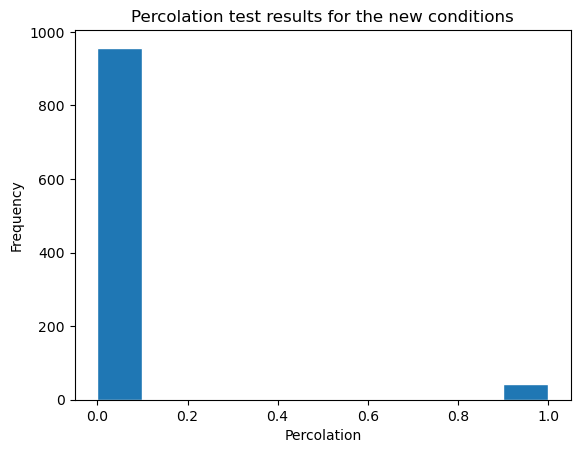

In [16]:
plt.figure()
plt.title('Percolation test results for the new conditions')
plt.hist(results_new, edgecolor = 'white')
plt.xlabel('Percolation')
plt.ylabel('Frequency')
plt.show()

In [17]:
mean_water_new = []
for i in range(1000):
    g = Grid()
    for j in range(60):
        g.update()
    water_levels = np.array(g.retrieve('water')).flatten()
    mean_water_new.append(np.mean(water_levels))

In [18]:
confint_new = confint(mean_water_new)

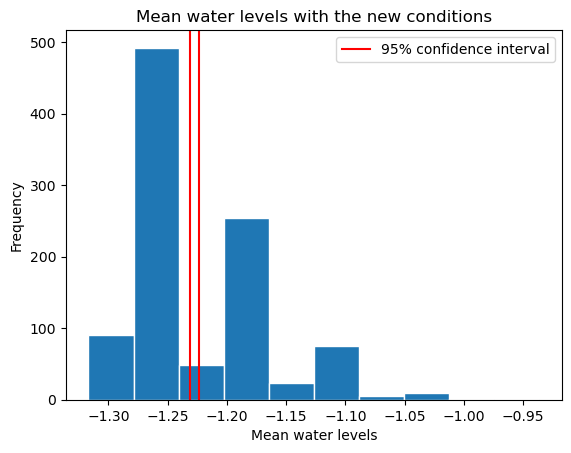

95% confidence interval:  [-1.2307397064454368, -1.223509851716117]


In [19]:
plt.figure()
plt.title('Mean water levels with the new conditions')
plt.hist(mean_water_new, edgecolor = 'white', bins = 10)
plt.axvline(confint_new[0], label = '95% confidence interval', color = 'red')
plt.axvline(confint_new[1], color = 'red')
plt.legend()
plt.xlabel('Mean water levels')
plt.ylabel('Frequency')
plt.show()
print('95% confidence interval: ', confint_new)

In [20]:
for i in range(5):
    g = Grid()
    for j in range(60):
        g.update()
    if g.percolation_test() == True:
        g.observe('flooded')

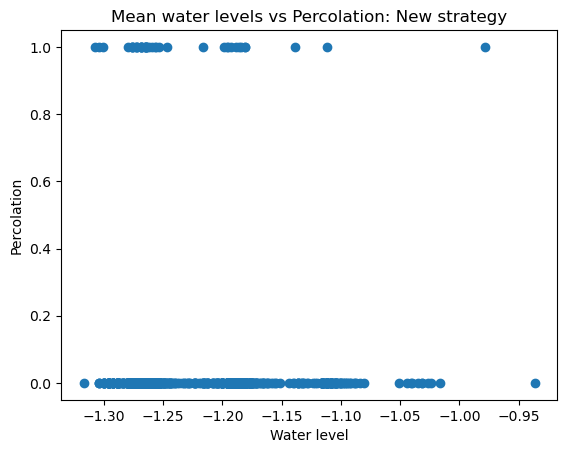

In [21]:
plt.figure()
plt.scatter(mean_water_new, results_new)
plt.title('Mean water levels vs Percolation: New strategy')
plt.xlabel('Water level')
plt.ylabel('Percolation')
plt.show()

### Cobweb plot

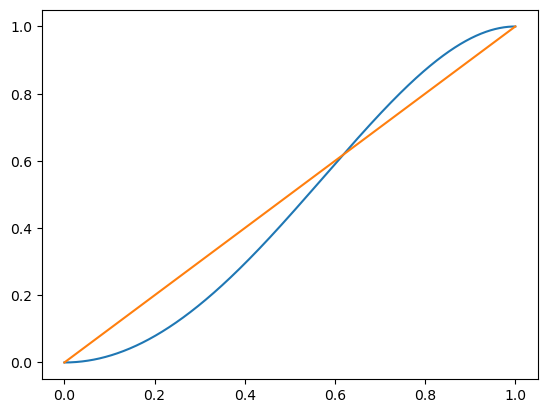

In [22]:
def f(x):
    return (x**4) + 4*(x**3)*(1-x) + 2*(x**2)*(1-x)**2

x = np.linspace(0,1,1000)
plot = [f(value) for value in x]
diagonal = [value for value in x]
plt.figure()
plt.plot(x, plot)
plt.plot(x, diagonal)
plt.show()

### Average probability of having a lower altitude neighbor in our model

In [23]:
g = Grid()
for i in range(60):
    g.update()
np.mean(g.flow)

0.8800000000000002